<a href="https://colab.research.google.com/github/RWLab/crypto-pod/blob/main/research/intraday_seasonal_patterns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Crypto Seasonal Patterns

This notebook supports this webinar:


The big idea:
* at any point a bunch of non-random trading is happening
* some of it probably has some daily regularity ("fund starts twapping every day at a certain hour")

So I was interested in: "Do the recent returns during some time of the day, explain future returns at that time?"

i.e. if SOL performed best at 1 UTC over the last 30 days, is it more likely to keep performing best in that hour tomorrow?


In [1]:
# snippet: rw load rwRtools v0.8
source("https://raw.githubusercontent.com/RWLab/rwRtools/master/examples/colab/load_libraries.R")
debug_msg <- load_libraries(load_rsims = FALSE, extra_libraries = c('lubridate', "glue", "tibbletime","roll","RcppRoll","Rcpp", "patchwork"), extra_dependencies = c('RcppParallel'))

# cat(debug_msg)

# Set chart options
options(repr.plot.width = 14, repr.plot.height=7)
theme_set(theme_bw())
theme_update(text = element_text(size = 20))

Using 2  CPUs for package installation

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)




bit (4.0.4 -> 4.0.5) [CRAN]


Installing 1 packages: bit

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



callr   (3.7.3    -> 3.7.5   ) [CRAN]
openssl (2.0.6    -> 2.1.1   ) [CRAN]
curl    (5.0.2    -> 5.2.0   ) [CRAN]
gargle  (1.5.1    -> 1.5.2   ) [CRAN]
zip     (2.3.0    -> 2.3.1   ) [CRAN]
arrow   (13.0.0.1 -> 14.0.2.1) [CRAN]
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/tmp/RtmpeQk3k0/remotesbe45389c3b/RWLab-rwRtools-88f4072/DESCRIPTION’ ... OK
* preparing ‘rwRtools’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted ‘LazyData’ from DESCRIPTION
* building ‘rwRtools_0.1.67.tar.gz’



In [2]:
# snippet: rw data auth v.0.1
rwlab_data_auth()
# load binance prices
prices <- rwRtools::crypto_get_binance_spot_1h()

Authorization successful!

ℹ Downloading binance_spot_1h.feather

✔ Saved binance_spot_1h.feather to binance/binance_spot_1h.feather  ( 891.9 Mb )





File successfully transferred


In [3]:
head(prices)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


Remove stuff we don't want. (just copying this from kris's trend notebook)

In [4]:
# remove LUNAUSDT from Friday 13 May 2022. Even though it continued to exist after this, there's no way you'd include it in your universe of tradable assets.
prices <- prices %>%
  filter(!(Ticker == "LUNAUSDT" & Datetime >= "2022-05-13"))

prices %>% head

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTCUSDT,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETHUSDT,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTCUSDT,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETHUSDT,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTCUSDT,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETHUSDT,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


Make a sensible universe - remove stables, wrapped coins, leveraged tokens. Take top n by rolling 30-day dollar volume.

In [5]:
# ditch stables and wrapped/leveraged tokens and keep only the data we need

# list of stablecoins from defi llama
url <- "https://stablecoins.llama.fi/stablecoins?includePrices=true"
response <- httr::GET(url)

stables <- response %>%
  content(as = "text", encoding = "UTF-8") %>%
  jsonlite::fromJSON(flatten = TRUE) %>%
  pluck("peggedAssets") %>%
  pull(symbol)

stables <- glue::glue("{stables}USDT")

# duplicates and others to remove
to_remove <- glue::glue("{c('BTCD', 'HBTC', 'IBBTC', 'RBTC', 'SBTC3', 'WNXM', 'WBTC', 'BNBBULL', 'BNBBEAR', 'EOSBULL', 'EOSBEAR', 'ETHBULL', 'ETHBEAR', 'XRPBULL', 'XRPBEAR')}USDT")

# Remove stablecoins and others
prices <- prices %>%
  filter(!Ticker %in% c(stables, to_remove)) %>%
  mutate(Ticker = str_replace(Ticker, "USDT$", ""))

head(prices)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>
BTC,2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009,202366.14,171,35.160503,150952.48
ETH,2017-08-17 04:00:00,301.13,302.57,298.00,301.61,125.668770,37684.80,129,80.563770,24193.44
BTC,2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916,100304.82,102,21.448071,92608.28
ETH,2017-08-17 05:00:00,301.61,303.28,300.00,303.10,377.672460,114043.28,202,328.104280,99079.80
BTC,2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691,31282.31,36,4.802861,20795.32
ETH,2017-08-17 06:00:00,302.40,304.44,301.90,302.68,303.866720,92034.44,182,259.286680,78525.95


In [6]:
# limit universe
trading_universe_size <- 50

universe <- prices %>%
  # just get the top n by trailing 30-day volume
  group_by(Ticker) %>%
  mutate(trail_volume = roll::roll_mean(`Quote asset volume`, 30*24)) %>%
  na.omit() %>%
  group_by(Datetime) %>%
  mutate(
    volume_rank = row_number(-trail_volume),
    is_universe = volume_rank <= trading_universe_size
  )

head(universe)

Ticker,Datetime,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,trail_volume,volume_rank,is_universe
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<int>,<lgl>
BTC,2017-09-16 09:00:00,3816.03,3839.75,3753.00,3753.08,76.39284,288969.0,431,19.24200,72926.08,145466.23,1,TRUE
ETH,2017-09-16 09:00:00,264.99,267.00,255.00,256.00,510.07931,133181.1,490,164.07393,42691.10,78536.56,2,TRUE
BTC,2017-09-16 10:00:00,3753.29,3753.29,3470.66,3480.00,175.25183,627740.7,778,58.97698,209869.88,146057.03,1,TRUE
ETH,2017-09-16 10:00:00,256.00,257.96,235.51,240.00,1385.45880,340142.1,697,349.70160,86958.16,78956.64,2,TRUE
BTC,2017-09-16 11:00:00,3490.00,3678.22,3490.00,3630.06,113.72828,409920.0,475,68.05315,246000.25,146487.05,1,TRUE
ETH,2017-09-16 11:00:00,241.00,252.00,236.11,249.99,555.04440,137007.9,387,304.23427,75306.66,78988.53,2,TRUE


Let's look for any obvious general intraday seasonality patterns first

In [7]:
returns <- universe %>%
  group_by(Ticker) %>%
  arrange(Datetime) %>%
  mutate(
    returns = log(Close/lag(Close)),
    trail_volatility = roll::roll_sd(returns, 7*24) * sqrt(365),
    vol_adjusted_returns = returns * (0.5 / lag(trail_volatility)), # 7 day trailing vol to size things by
    hour = lubridate::hour(Datetime)
  ) %>%
  na.omit()

Box plot of returns by hour

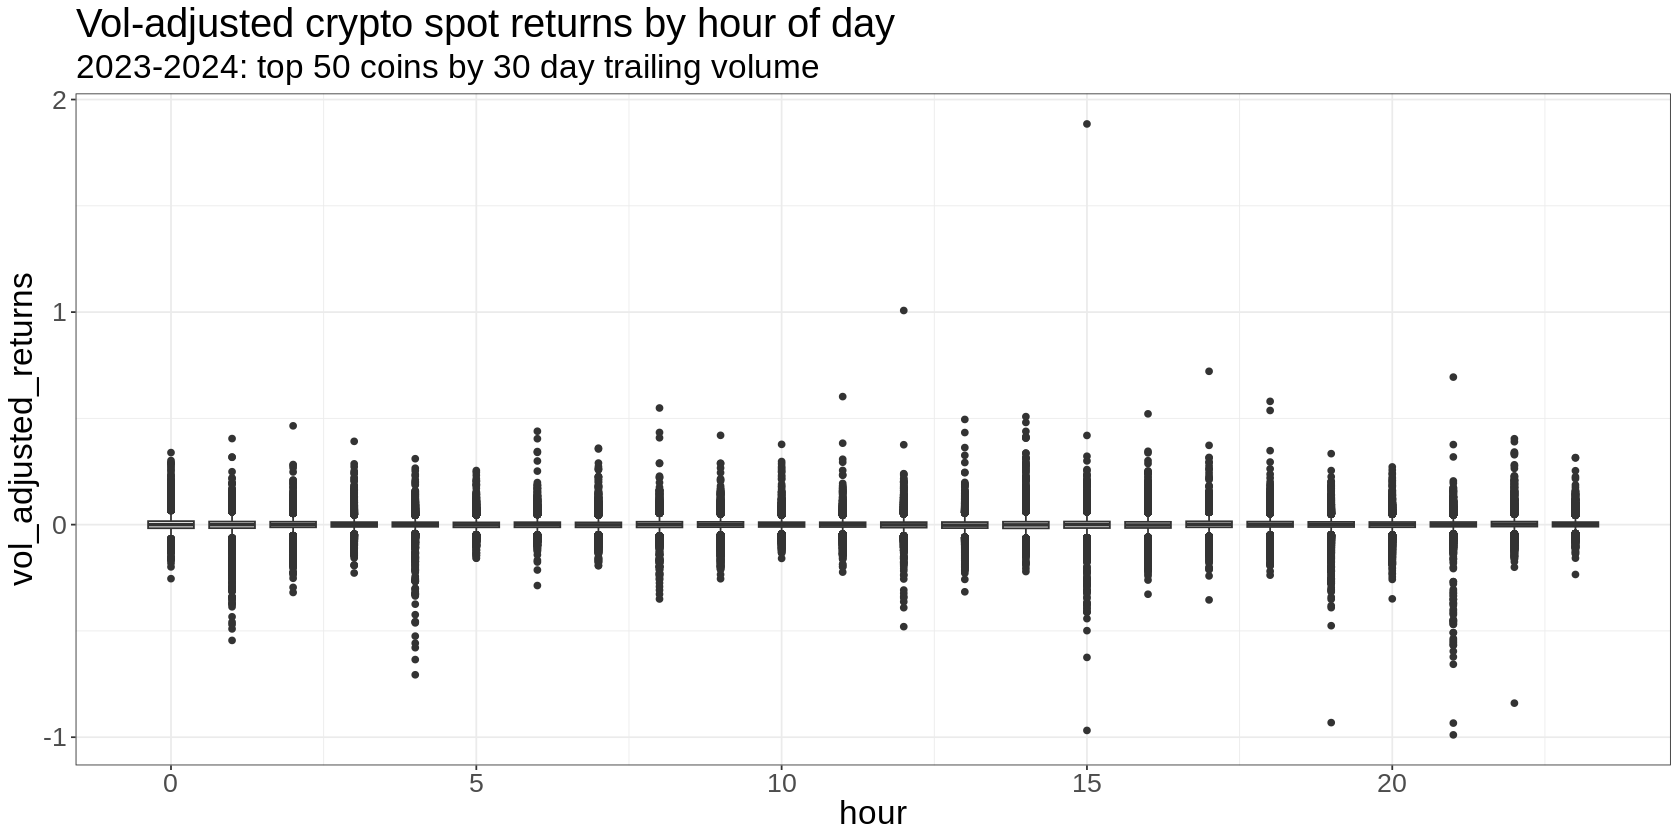

In [8]:
returns %>%
  filter(is_universe, Datetime >= '2023-01-01') %>%
  group_by(hour) %>%
  ggplot(aes(x=hour, group=hour, y=vol_adjusted_returns)) + geom_boxplot() + ggtitle('Vol-adjusted crypto spot returns by hour of day', subtitle = '2023-2024: top 50 coins by 30 day trailing volume')

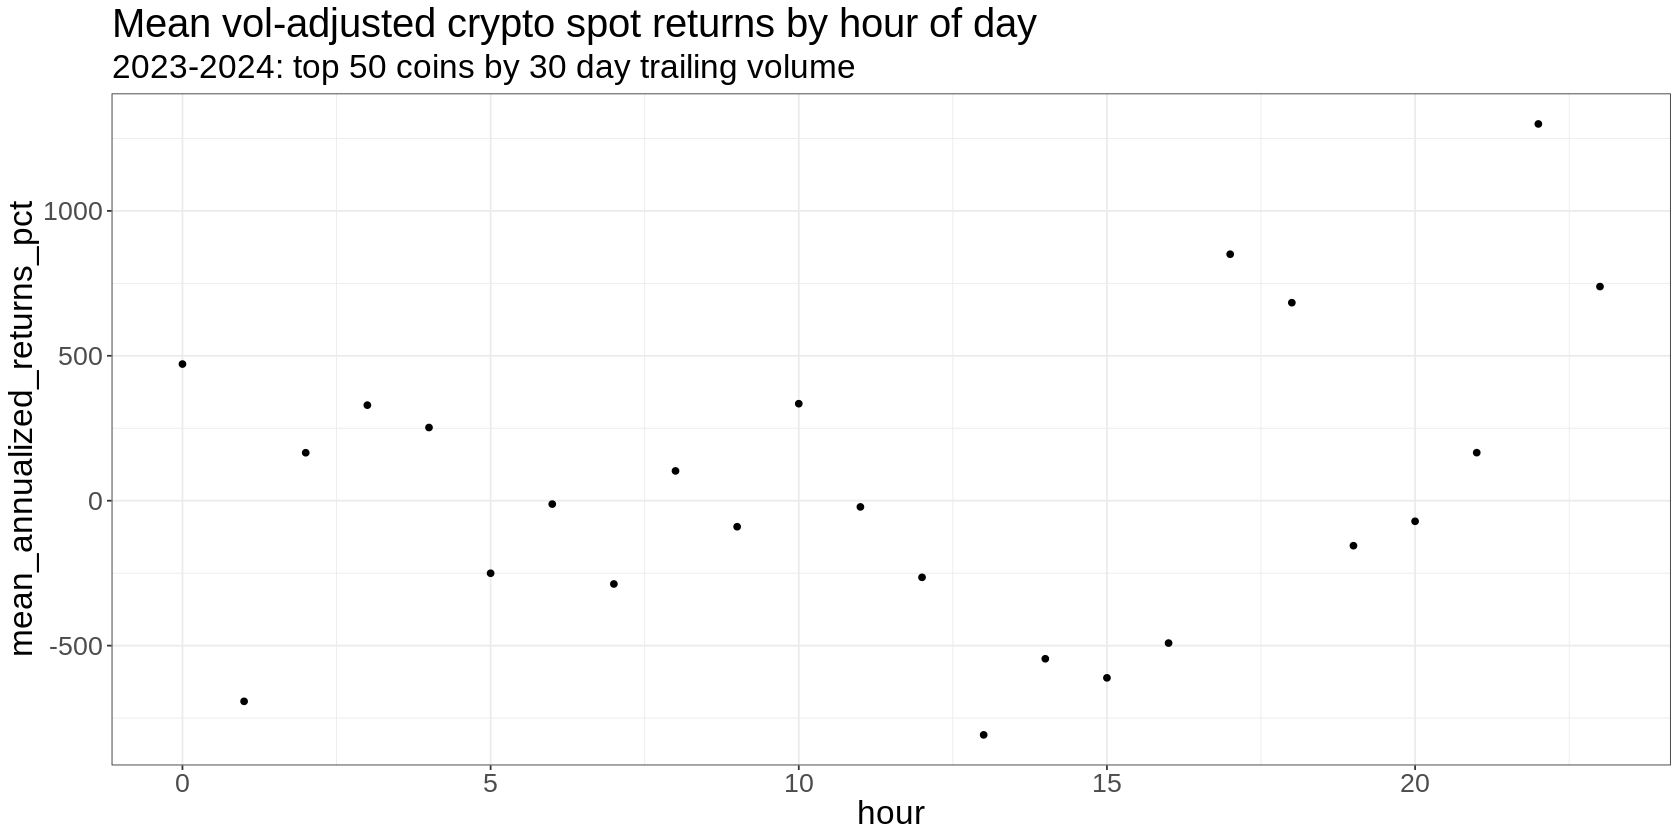

In [9]:
returns %>%
  filter(is_universe, Datetime >= '2023-01-01') %>%
  group_by(hour) %>%
  summarize(mean_annualized_returns_pct = mean(vol_adjusted_returns) * 365 * 12 * 100) %>%
  ggplot(aes(x=hour, y=mean_annualized_returns_pct)) + geom_point() +
    ggtitle('Mean vol-adjusted crypto spot returns by hour of day', subtitle = '2023-2024: top 50 coins by 30 day trailing volume')

some hint of exceess returns prior to 0 UTC and low returns immediately after - as some have anecodtally mentioned to me. Does it hold up if we look at each year?

`summarise()` has grouped output by 'hour'. You can override using the
`.groups` argument.


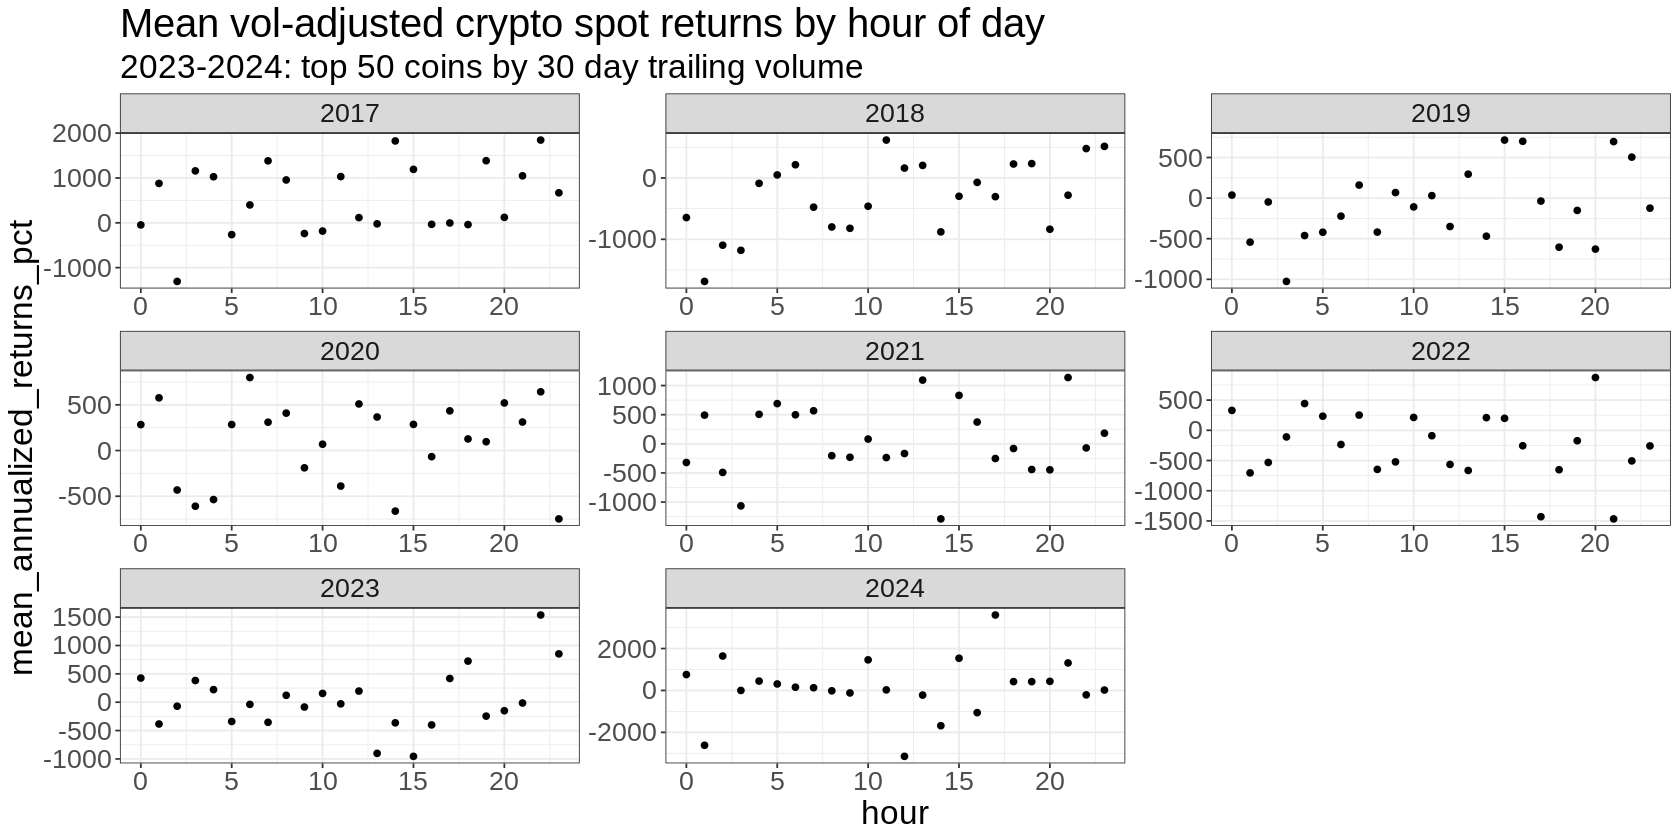

In [10]:
returns %>%
  mutate(year = lubridate::year(Datetime)) %>%
  filter(is_universe) %>%
  group_by(hour, year) %>%
  summarize(mean_annualized_returns_pct = mean(vol_adjusted_returns) * 365 * 12 * 100) %>%
  ggplot(aes(x=hour, y=mean_annualized_returns_pct)) + geom_point() + facet_wrap(~year, scales='free') +
    ggtitle('Mean vol-adjusted crypto spot returns by hour of day', subtitle = '2023-2024: top 50 coins by 30 day trailing volume')

Mostly saw that pattern in 2023. But end of day (UTC) does seeem to show slight excess returns.

That's not what we wanna look at though.

# Looking for Persistence of Seasonality Patterns



Is there any persistence to what tickers tend to do better at certain times of the day?

For each ticker, rank its risk-adjsuted returns for each hour over some lookback. Is that rank correlated to future returns over that hour?

Here we
* calculate mean-vol adjusted returns for each ticker each hour
* calculate the rolling 30 day returns for each ticker each hour
* for each ticker, for each day, rank each of the hourse
** 1 = worst performing hour over the last 30 days
** 2 = best performing hour over the last 30 hours

Then look to see if that (lagged) rank predicts next days vol-adjusted returns for that ticker on that hour.

In [11]:
lookback <- 30 # in days

hour_persistence <- returns %>%
  mutate(date = as.Date(Datetime)) %>%
  group_by(Ticker, hour) %>%
  arrange(Datetime) %>%
  mutate(trail_perf = roll::roll_mean(vol_adjusted_returns, lookback)) %>%
  na.omit() %>%
  # now calculate the rank for each ticker
  group_by(Ticker, date) %>%
  mutate(rank = row_number(trail_perf)) %>%
  # Now does that lagged rank predict returns
  group_by(Ticker, hour) %>%
  arrange(Datetime) %>%
  mutate(lagged_rank = lag(rank)) %>%
  na.omit()


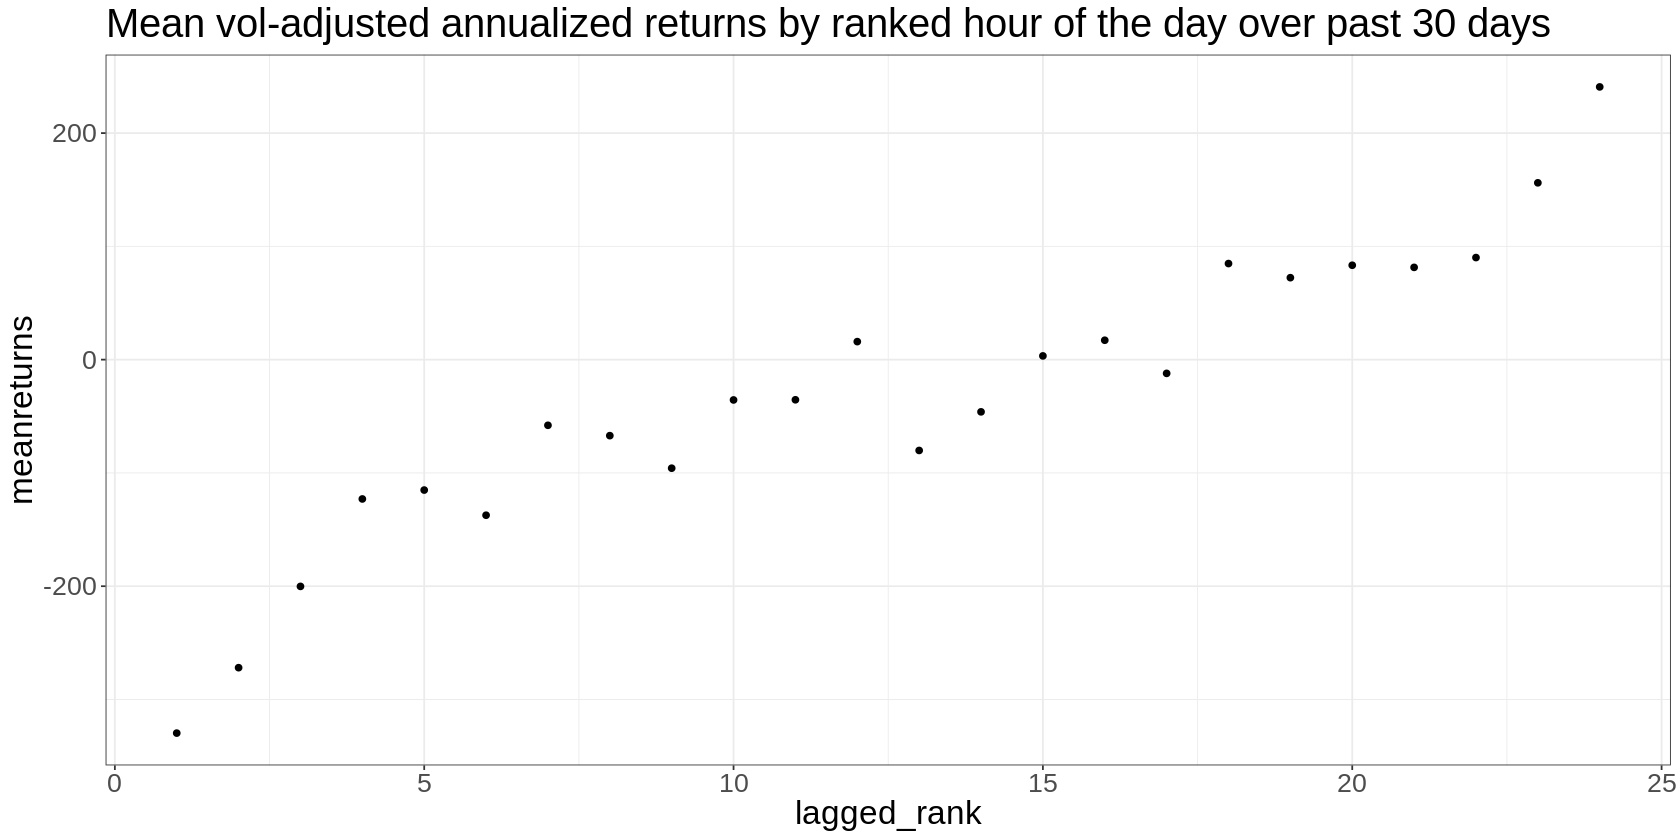

In [12]:
hour_persistence %>%
  filter(is_universe) %>%
  group_by(lagged_rank) %>%
  summarize(meanreturns = mean(vol_adjusted_returns) * 365 * 12 * 100) %>%
  ggplot(aes(x=lagged_rank, y=meanreturns)) + geom_point() + ggtitle('Mean vol-adjusted annualized returns by ranked hour of the day over past 30 days')


strong effect. let's see if it exists so strongly in the most obvious ticker, bitcoin

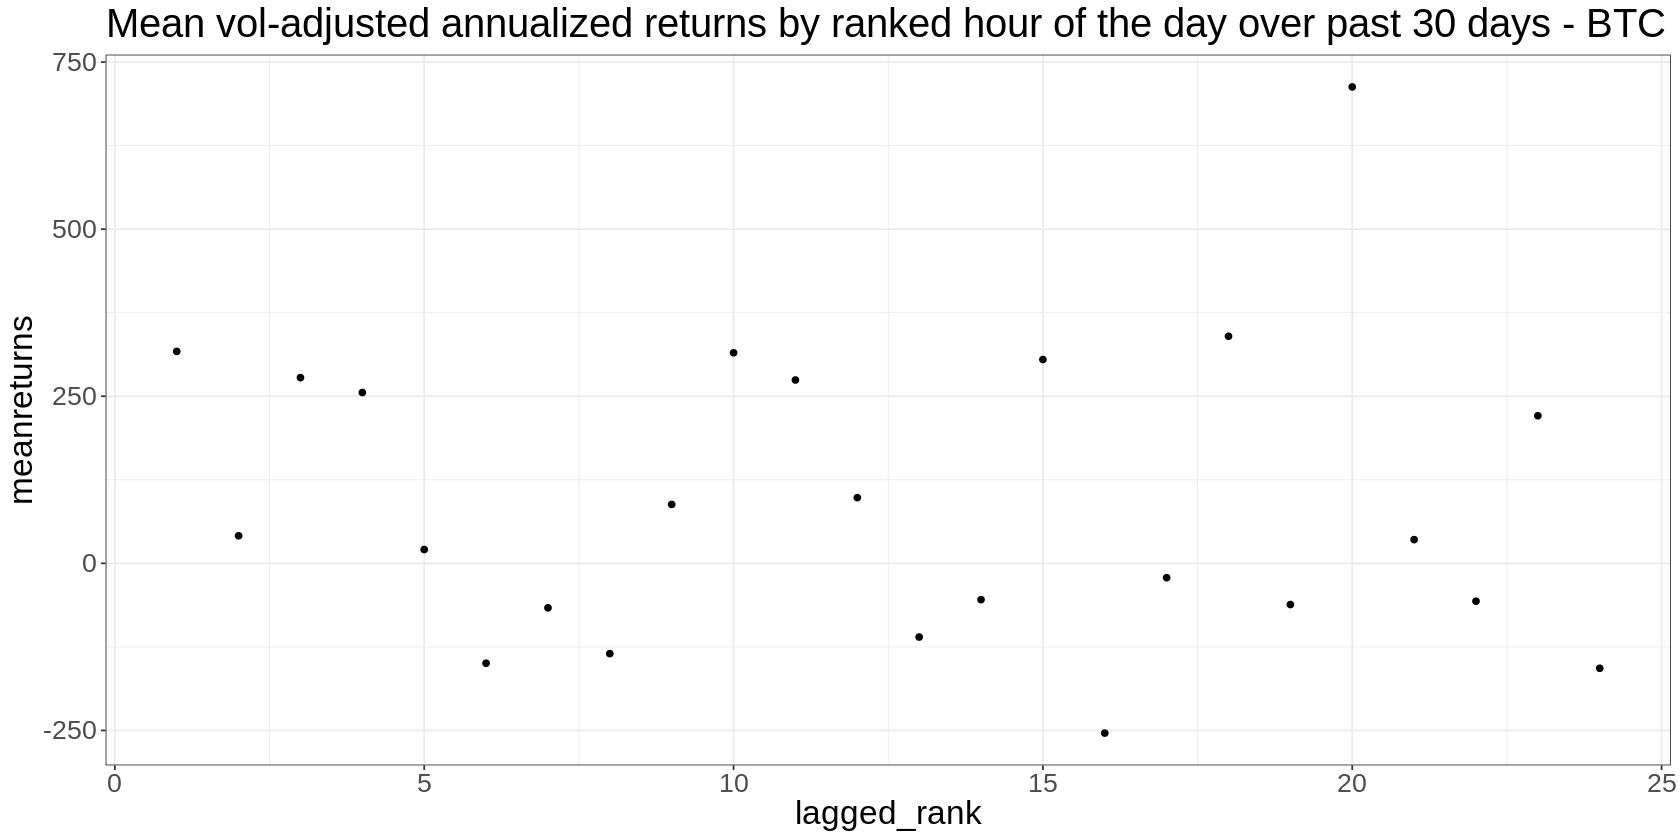

In [13]:
hour_persistence %>%
  filter(Ticker == 'BTC') %>%
  group_by(lagged_rank) %>%
  summarize(meanreturns = mean(vol_adjusted_returns) * 365 * 12 * 100) %>%
  ggplot(aes(x=lagged_rank, y=meanreturns)) + geom_point() + ggtitle('Mean vol-adjusted annualized returns by ranked hour of the day over past 30 days - BTC')

not so much.

we'll do a factor plot... and rank each ticker/hour long/short in proportion to how well it did in the last 30 days.

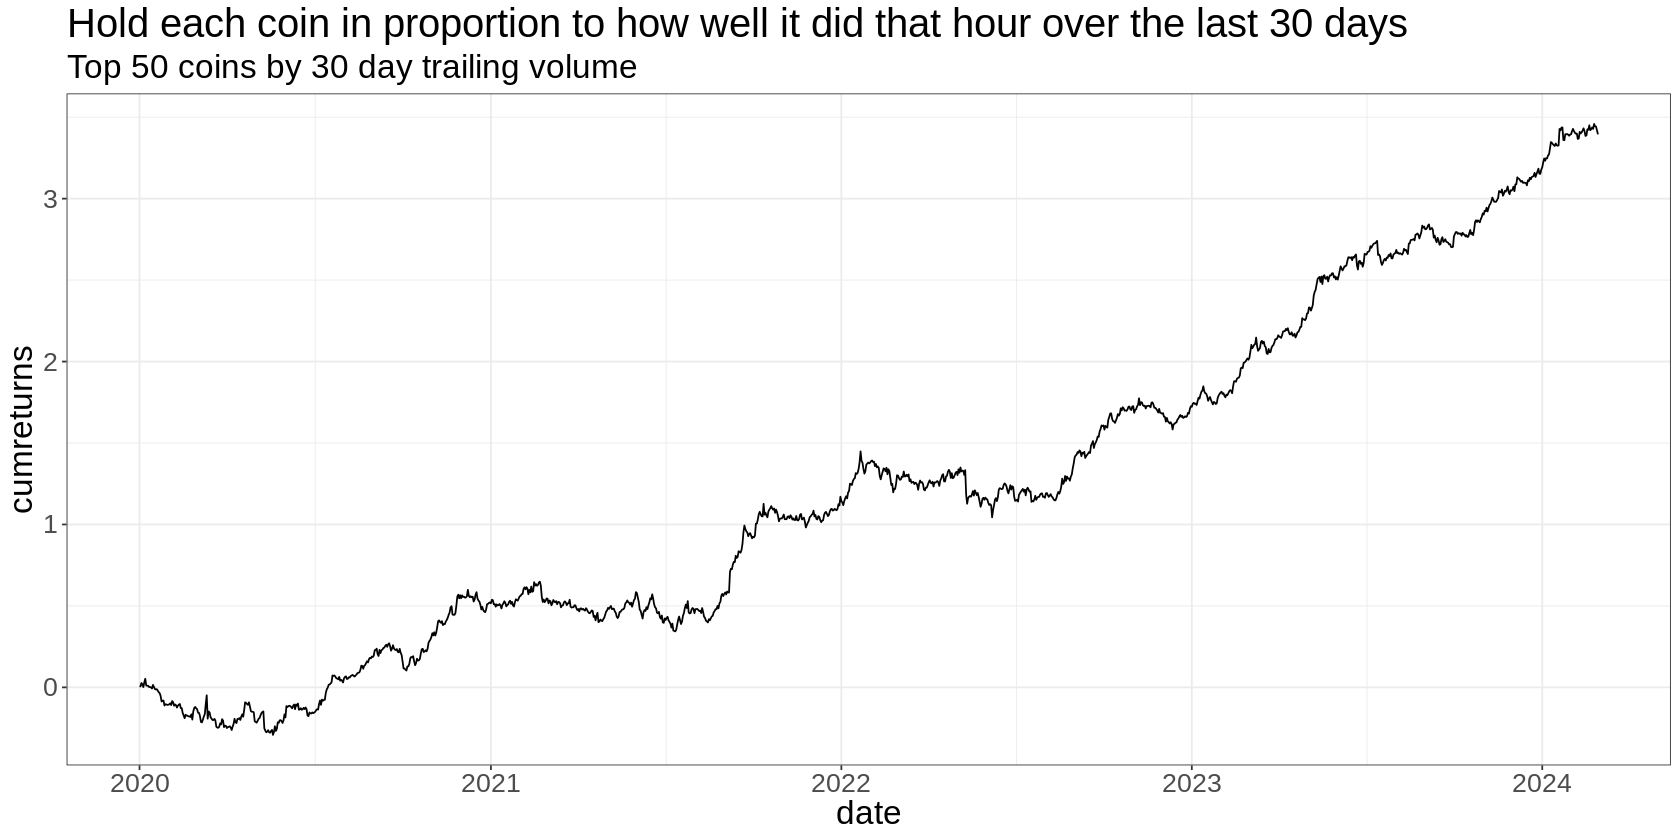

In [14]:
hour_persistence %>%
  filter(date >= '2020-01-01') %>%
  filter(is_universe) %>%
  mutate(date = as.Date(Datetime)) %>%
  mutate(weight = lagged_rank - 12.5) %>%
  group_by(date) %>%
  summarize(mean_returns = mean(vol_adjusted_returns * weight)) %>%
  arrange(date) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() +
  ggtitle('Hold each coin in proportion to how well it did that hour over the last 30 days', subtitle = 'Top 50 coins by 30 day trailing volume')

looks pretty good.

here's something that looks more like a trading strategy. simply long the each ticker in its best hour and short it in its worst hour.

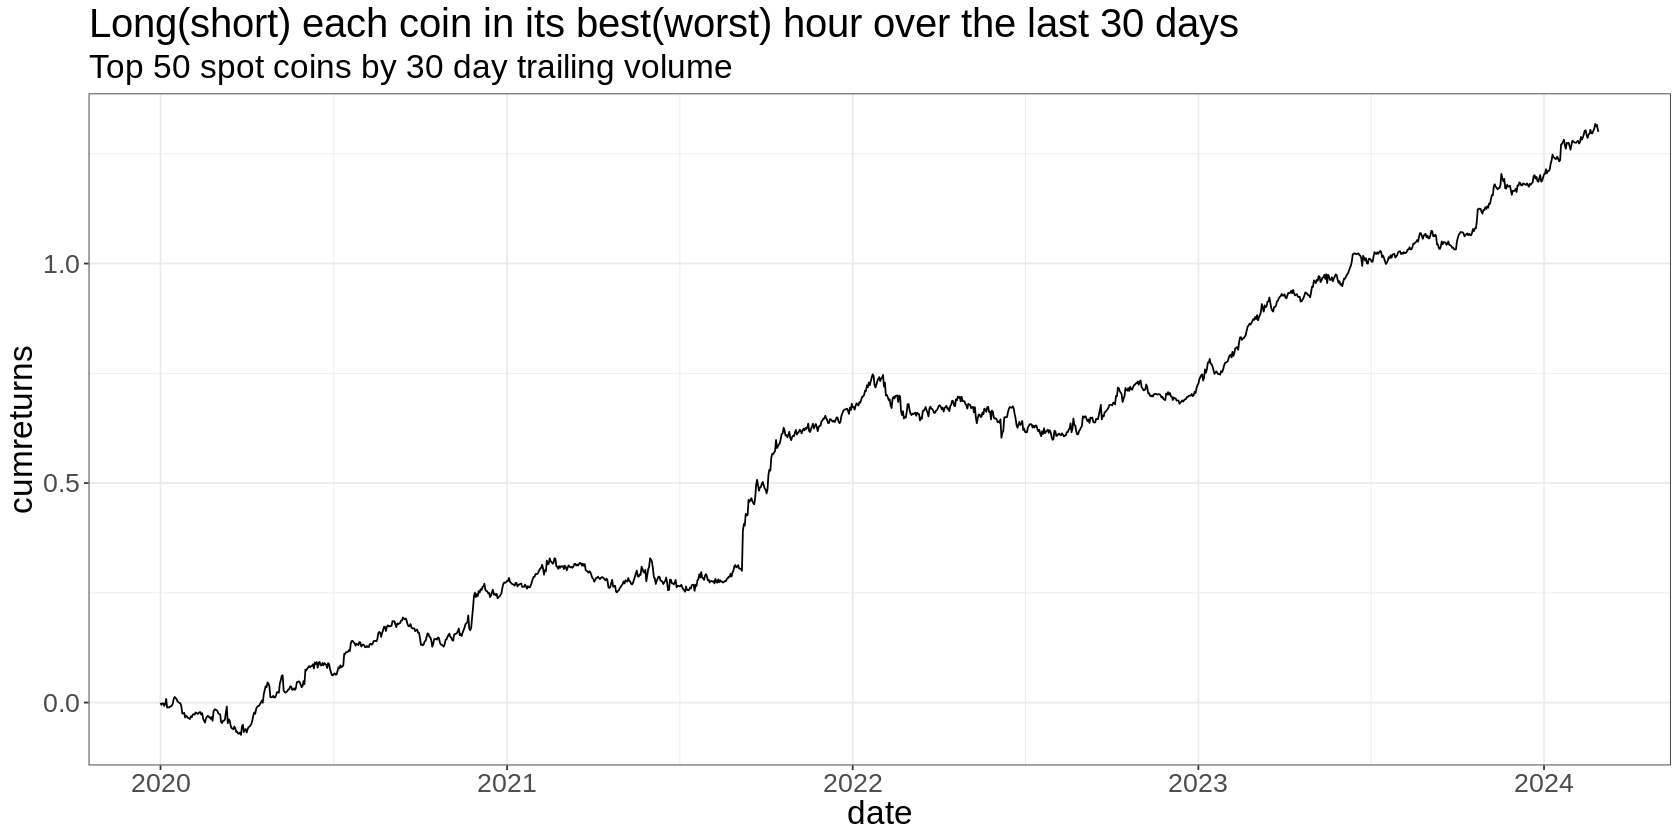

In [15]:
hour_persistence %>%
  filter(date >= '2020-01-01') %>%
  filter(is_universe) %>%
  mutate(date = as.Date(Datetime)) %>%
  filter(lagged_rank %in% c(1,24)) %>%
  mutate(weight = case_when(lagged_rank < 12 ~ -1, lagged_rank >= 12 ~ 1)) %>%
  group_by(date) %>%
  summarize(mean_returns = mean(vol_adjusted_returns * weight)) %>%
  arrange(date) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() +
  ggtitle('Long(short) each coin in its best(worst) hour over the last 30 days', subtitle = 'Top 50 spot coins by 30 day trailing volume')

as a sense check, what if we approached this from the other direction?

For each hour, rank the assets. do the assets that did best in a given hour tend to outperform.

In [16]:
lookback <- 30 # in days

hour_asset_persistence <- returns %>%
  mutate(date = as.Date(Datetime)) %>%
  group_by(Ticker, hour) %>%
  arrange(Datetime) %>%
  mutate(trail_perf = roll::roll_mean(vol_adjusted_returns, lookback)) %>%
  na.omit() %>%
  filter(is_universe) %>%
  # now calculate the rank of each asset for each ticker
  group_by(hour, date) %>%
  mutate(rank = row_number(trail_perf)) %>%
  # Now does that lagged rank predict returns
  group_by(Ticker, hour) %>%
  arrange(Datetime) %>%
  mutate(lagged_rank = lag(rank)) %>%
  na.omit()

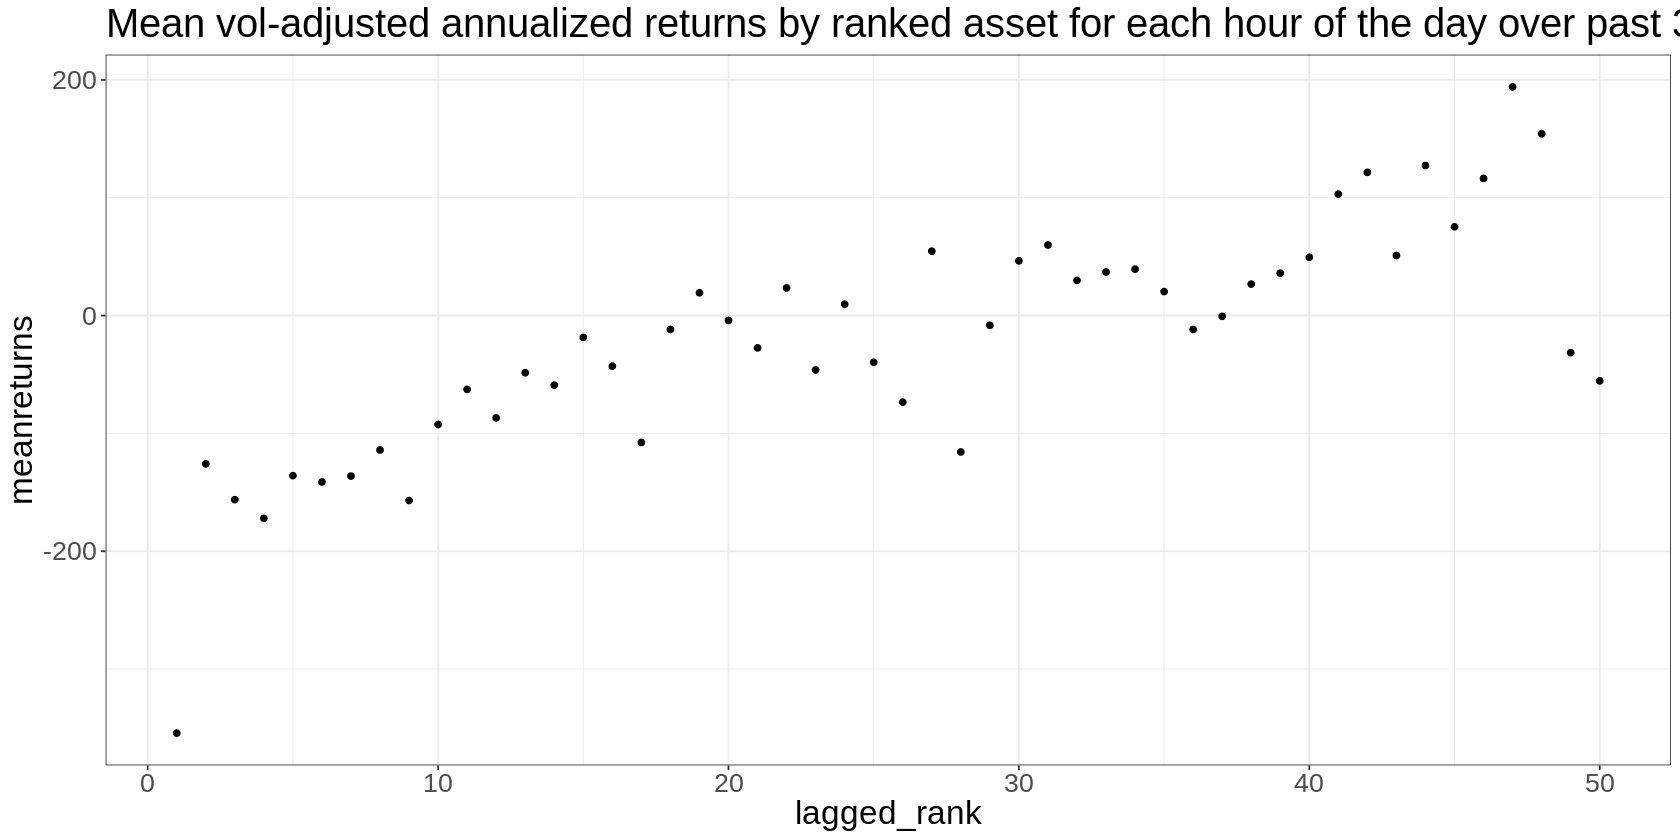

In [17]:
hour_asset_persistence %>%
  filter(is_universe) %>%
  group_by(lagged_rank) %>%
  summarize(meanreturns = mean(vol_adjusted_returns) * 365 * 12 * 100) %>%
  ggplot(aes(x=lagged_rank, y=meanreturns)) + geom_point() + ggtitle('Mean vol-adjusted annualized returns by ranked asset for each hour of the day over past 30 days')

we also see a clear effect there, which is comforting.

this is probably untradeable like this. let's break the day down into bigger chunks. say 6 hour chunks.

`summarise()` has grouped output by 'date', 'Ticker'. You can override using
the `.groups` argument.


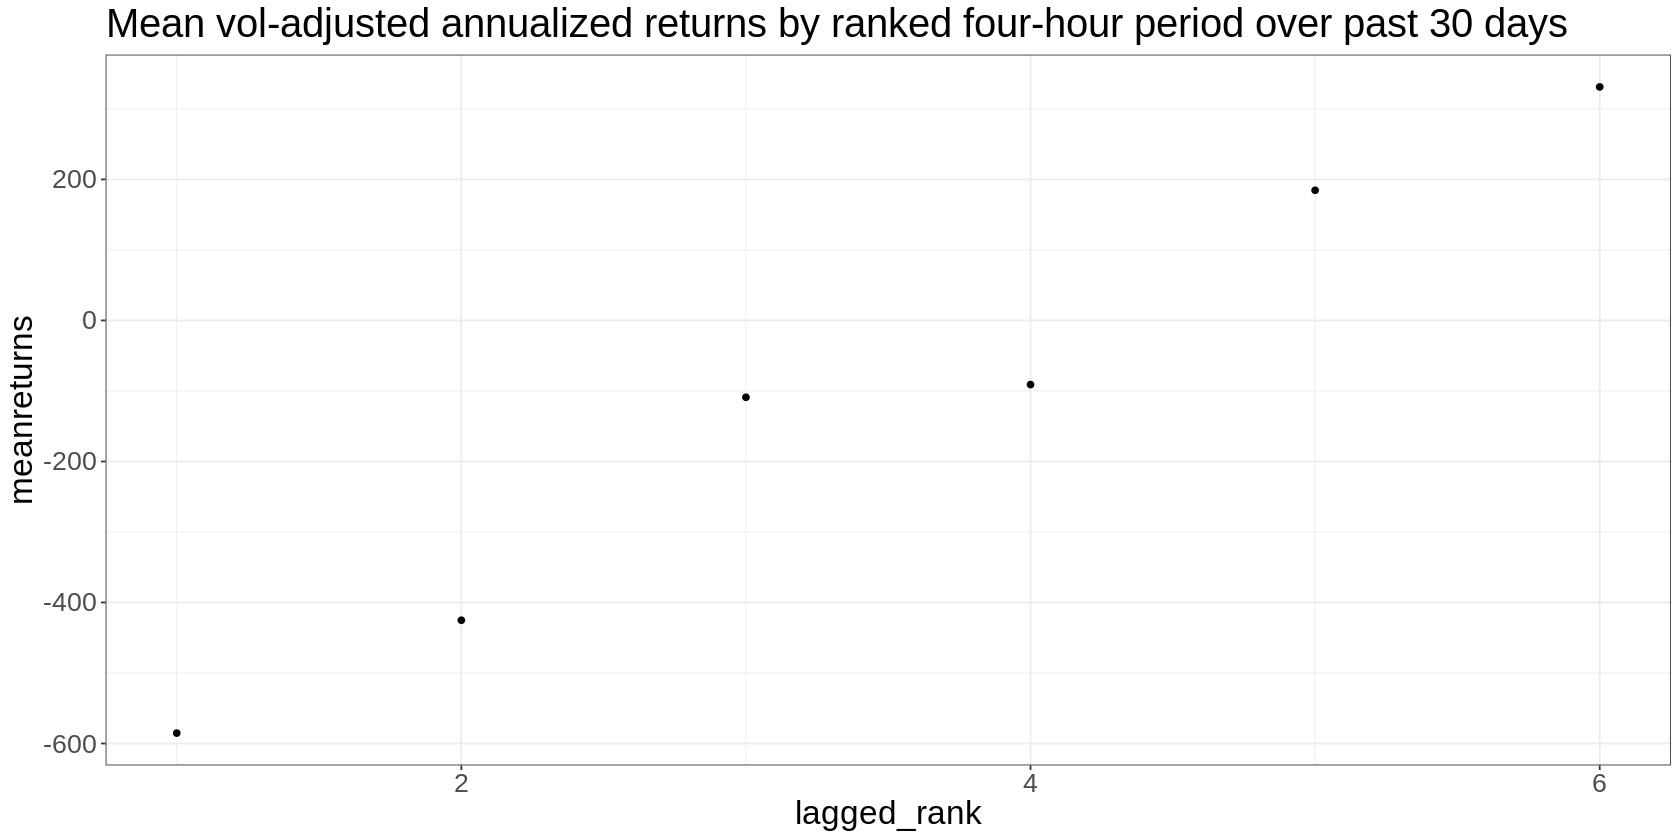

In [36]:
lookback <- 30 # in days

fourhour_persistence <- returns %>%
  mutate(date = as.Date(Datetime)) %>%
  mutate(hour_chunk = ceiling((hour+1) * (6/24))) %>% # four six-hour chunks
  group_by(date, Ticker, hour_chunk) %>%
  summarize(vol_adjusted_returns = sum(vol_adjusted_returns), is_universe = last(is_universe)) %>%
  group_by(Ticker, hour_chunk) %>%
  arrange(date) %>%
  mutate(trail_perf = roll::roll_mean(vol_adjusted_returns, lookback)) %>%
  na.omit() %>%
  # now calculate the rank for each ticker
  group_by(Ticker, date) %>%
  mutate(rank = row_number(trail_perf)) %>%
  # Now does that lagged rank predict returns
  group_by(Ticker, hour_chunk) %>%
  arrange(date) %>%
  mutate(lagged_rank = lag(rank)) %>%
  na.omit()

fourhour_persistence %>%
  filter(is_universe) %>%
  group_by(lagged_rank) %>%
  summarize(meanreturns = mean(vol_adjusted_returns) * 365 * 12 * 100) %>%
  ggplot(aes(x=lagged_rank, y=meanreturns)) + geom_point() + ggtitle('Mean vol-adjusted annualized returns by ranked four-hour period over past 30 days')

still see an effect

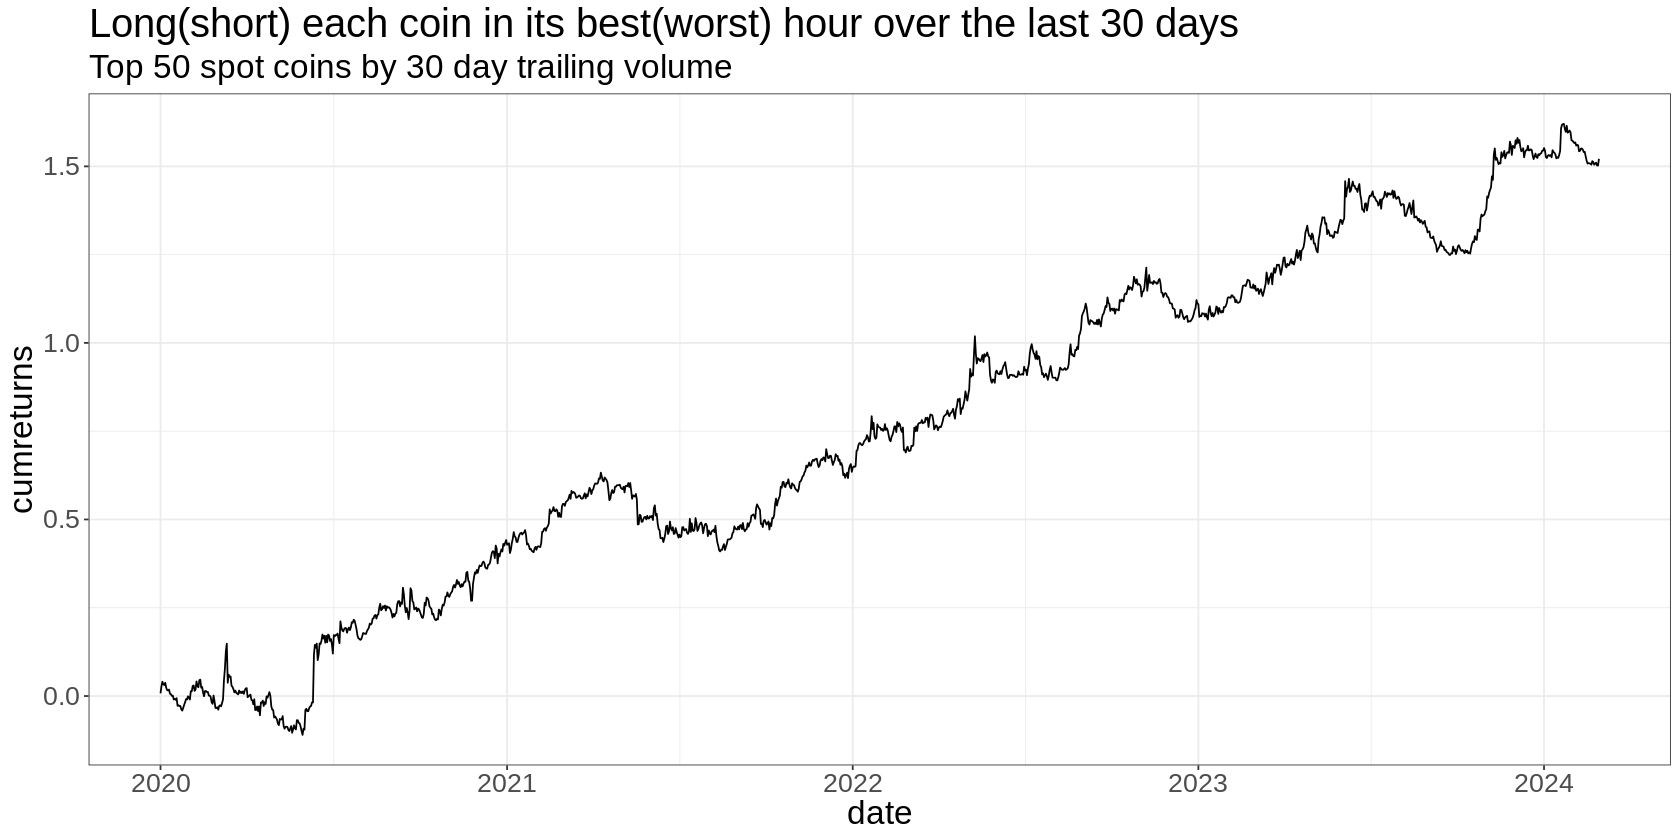

In [38]:
hour_persistence %>%
  filter(date >= '2020-01-01') %>%
  filter(is_universe) %>%
  filter(lagged_rank %in% c(1,6)) %>%
  mutate(weight = case_when(lagged_rank < 3.5 ~ -1, lagged_rank >= 3.5 ~ 1)) %>%
  group_by(date) %>%
  summarize(mean_returns = mean(vol_adjusted_returns * weight)) %>%
  arrange(date) %>%
  mutate(cumreturns = cumsum(mean_returns)) %>%
  ggplot(aes(x=date, y=cumreturns)) + geom_line() +
  ggtitle('Long(short) each coin in its best(worst) four hours over the last 30 days', subtitle = 'Top 50 spot coins by 30 day trailing volume')

still looks pretty good huh?

# Do we see day of week seasonal effects like this too?

Let's look at day of week seasonal effects in the same way.

In [18]:
daily <- returns %>%
  mutate(date = as.Date(Datetime)) %>%
  group_by(Ticker, date) %>%
  arrange(Datetime) %>%
  summarize(
    Close = last(Close),
    volume = sum(`Quote asset volume`),
    volume_rank = last(volume_rank),
    is_universe = last(is_universe),
    vol_adjusted_returns = sum(vol_adjusted_returns)
  )

`summarise()` has grouped output by 'Ticker'. You can override using the
`.groups` argument.


In [19]:
daily %>% tail()

Ticker,date,Close,volume,volume_rank,is_universe,vol_adjusted_returns
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>
ZRX,2024-02-23,0.3514,3736211,163,FALSE,-0.005473025
ZRX,2024-02-24,0.3621,3757179,162,FALSE,0.078683511
ZRX,2024-02-25,0.3711,2705483,172,FALSE,0.064862739
ZRX,2024-02-26,0.3725,5179430,212,FALSE,0.008248313
ZRX,2024-02-27,0.3796,4185771,231,FALSE,0.051840279
ZRX,2024-02-28,0.3926,3790237,236,FALSE,0.095065534


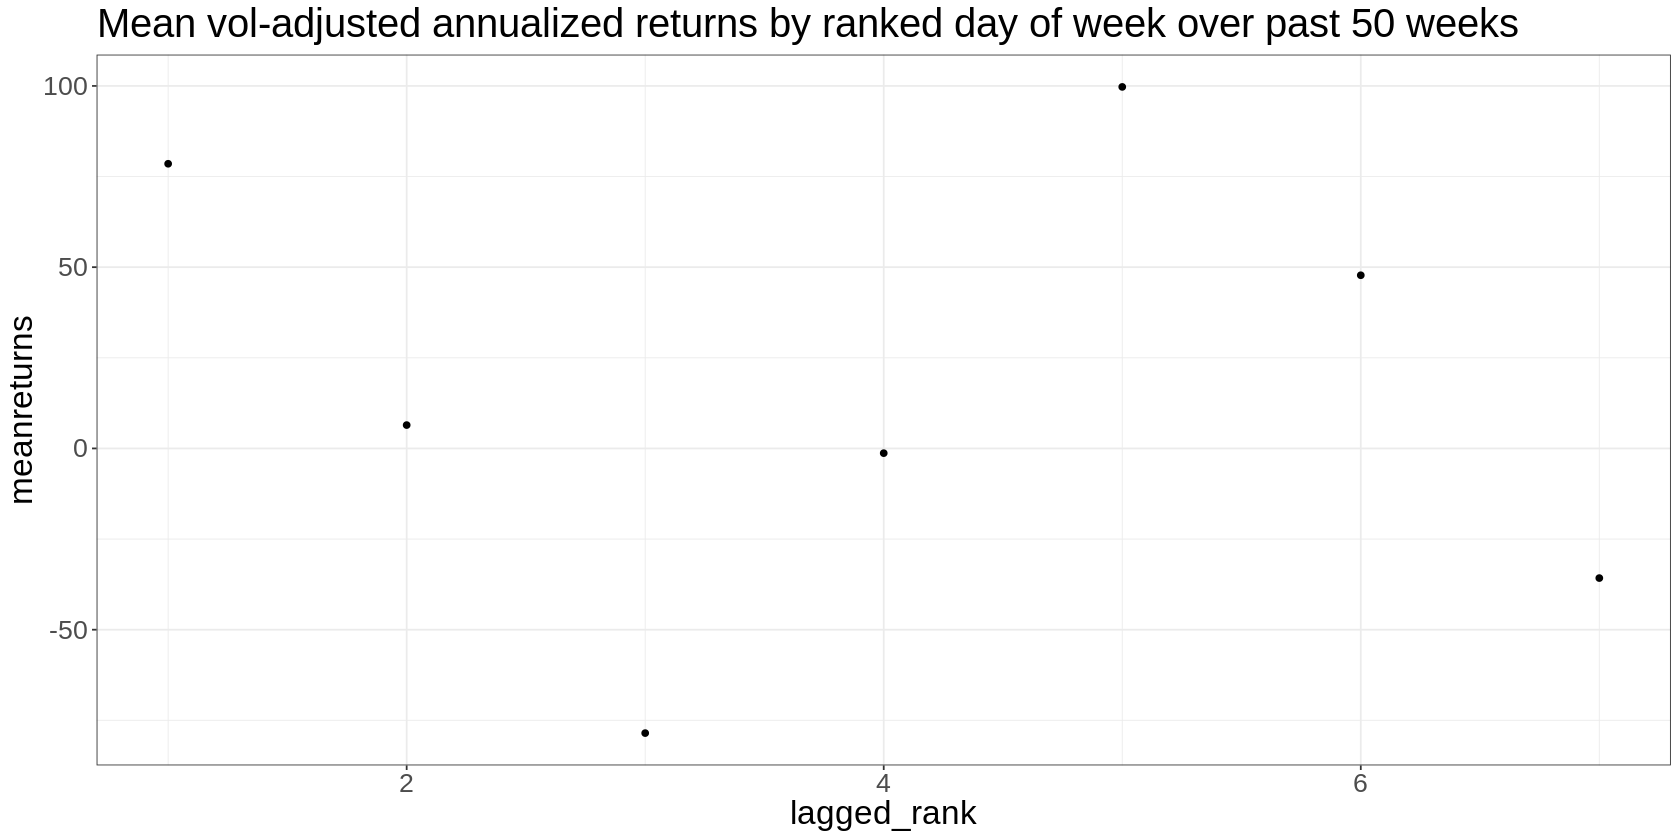

In [20]:
lookback <- 50 # in weeks

dow_persistence <- daily %>%
  mutate(
    dow = lubridate::wday(date),
    sow = lubridate::floor_date(date, 'week')
  ) %>%
  group_by(Ticker, dow) %>%
  arrange(date) %>%
  mutate(trail_perf = roll::roll_mean(vol_adjusted_returns, lookback)) %>%
  na.omit() %>%
  # now calculate the rank for each ticker
  group_by(Ticker, sow) %>%
  mutate(rank = row_number(trail_perf)) %>%
  # Now does that lagged rank predict returns
  group_by(Ticker, dow) %>%
  arrange(date) %>%
  mutate(lagged_rank = lag(rank)) %>%
  na.omit()

dow_persistence %>%
  filter(date >= '2020-01-01') %>%
  filter(is_universe) %>%
  group_by(lagged_rank) %>%
  summarize(meanreturns = mean(vol_adjusted_returns) * 365 * 100) %>%
  ggplot(aes(x=lagged_rank, y=meanreturns)) + geom_point() + ggtitle('Mean vol-adjusted annualized returns by ranked day of week over past 50 weeks')

Not much evidence of a persistence effect if we look back 50 weeks.

In [21]:
lookback <- 5 # in weeks

dow_persistence <- daily %>%
  mutate(
    dow = lubridate::wday(date),
    sow = lubridate::floor_date(date, 'week')
  ) %>%
  group_by(Ticker, dow) %>%
  arrange(date) %>%
  mutate(trail_perf = roll::roll_mean(vol_adjusted_returns, lookback)) %>%
  na.omit() %>%
  # now calculate the rank for each ticker
  group_by(Ticker, sow) %>%
  mutate(rank = row_number(trail_perf)) %>%
  # Now does that lagged rank predict returns
  group_by(Ticker, dow) %>%
  arrange(date) %>%
  mutate(lagged_rank = lag(rank)) %>%
  na.omit()

dow_persistence %>% tail()



Ticker,date,Close,volume,volume_rank,is_universe,vol_adjusted_returns,dow,sow,trail_perf,rank,lagged_rank
<chr>,<date>,<dbl>,<dbl>,<int>,<lgl>,<dbl>,<dbl>,<date>,<dbl>,<int>,<int>
YFI,2024-02-28,8.794e+03,7787976,185,FALSE,0.120482491,4,2024-02-25,0.013570552,3,3
YGG,2024-02-28,6.075e-01,14263952,143,FALSE,0.009619709,4,2024-02-25,0.024555588,3,4
ZEC,2024-02-28,2.906e+01,7640844,167,FALSE,0.016653873,4,2024-02-25,0.059551979,3,5
ZEN,2024-02-28,1.148e+01,4790737,124,FALSE,0.061834461,4,2024-02-25,0.045602489,3,5
ZIL,2024-02-28,2.844e-02,18685955,149,FALSE,0.216128310,4,2024-02-25,0.065595334,3,5
ZRX,2024-02-28,3.926e-01,3790237,236,FALSE,0.095065534,4,2024-02-25,0.008442327,3,3


but some evidence of a mean-reversion effects over very short horizon.

is this real or just random? hard to tell from this.

# Future Steps

- look at hour of day seasonality in bigger chunks (4-6 months, for example)
- investigate whether there's any evidence for short term day of week mean-reversion (can't really think of one)